# Sistema Inteligente de Detección de Fraude en Transacciones Financieras

**Objetivo:** Entrenar un modelo de ML que clasifique transacciones como legítimas o fraudulentas.

**Dataset:** Credit Card Fraud Detection (Kaggle)

**Metodología:** CRISP-DM

**Autores:** Oscar Garza, Elizabeth Uresti, Gael Lozano, Adrian Serrato

## 1. Business Understanding

### Problema
El fraude financiero genera pérdidas millonarias. Necesitamos un sistema que detecte transacciones anómalas.

### Métrica clave
**Recall (Sensibilidad):** Queremos capturar el máximo de fraudes posibles, aunque tengamos algunos falsos positivos.

### Objetivo técnico
Entrenar un clasificador con **Recall > 0.85** y **F1-Score > 0.80** en el conjunto de prueba.

**Metricas Clave**

Escalado correcto sin data leakage

Entrenando modelo con CV correcto...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores parámetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 1}

EVALUACIÓN CON THRESHOLD DEFAULT (0.5)

MÉTRICAS POR CLASE:
----------------------------------------------------------------------
Clase      Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
0 (Legit)  0.9998       0.9990       0.9994       56822
1 (Fraud)  0.6071       0.8673       0.7143       98
----------------------------------------------------------------------
Accuracy                             0.9988       56962
Macro Avg  0.8035       0.9332       0.8568       56962
----------------------------------------------------------------------

MATRIZ DE CONFUSIÓN:
----------------------------------------
                     Pred

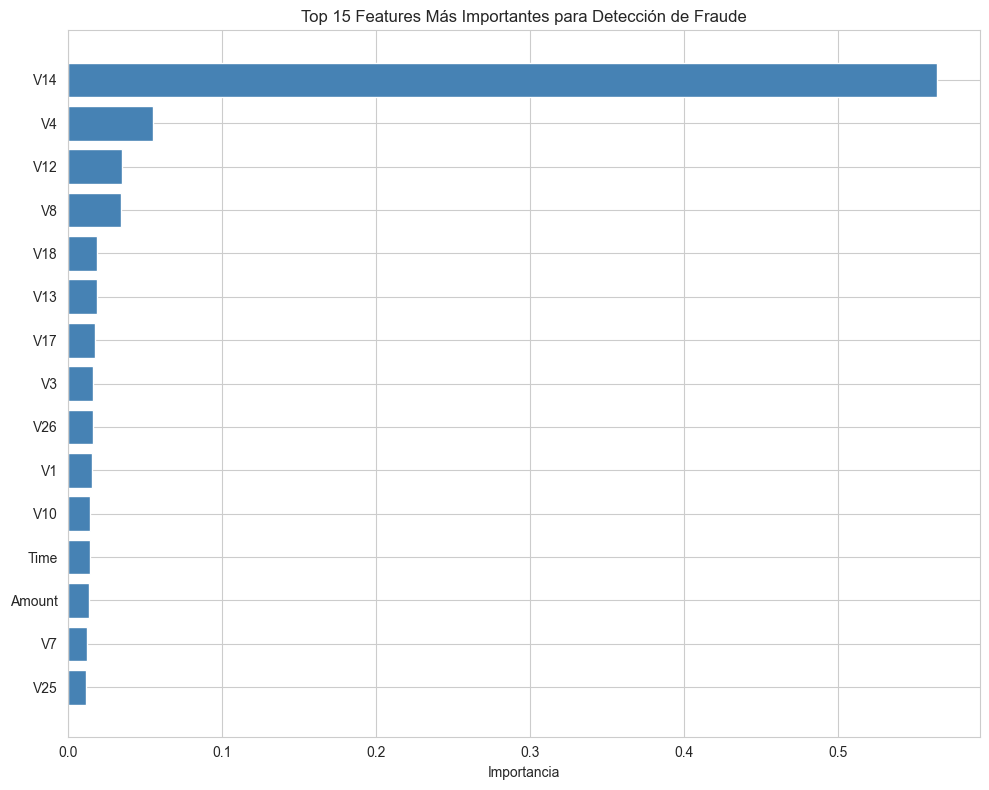

TOP 10 FEATURES MÁS IMPORTANTES
   1. V14        → 0.563941
   2. V4         → 0.055509
   3. V12        → 0.035447
   4. V8         → 0.034823
   5. V18        → 0.019031
   6. V13        → 0.018895
   7. V17        → 0.017719
   8. V3         → 0.016535
   9. V26        → 0.016265
  10. V1         → 0.015837

Artefactos guardados: model_final.pkl, scaler.pkl, model_columns.pkl, optimal_threshold.pkl
EJEMPLO DE PREDICCIÓN
  Transacción real:          LEGÍTIMA
  Probabilidad de fraude:    0.00%
  Clasificación:             LEGÍTIMA
  Nivel de confianza:        HIGH
  Threshold usado:           0.9721
  Recomendación:             APROBAR - Transacción normal

PIPELINE COMPLETO EJECUTADO CON ÉXITO


In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Configurar pandas para mostrar todo sin truncar
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Cargar datos
df = pd.read_csv('data/creditcard.csv')
X = df.drop('Class', axis=1)
y = df['Class']

# PRIMERO hacer el split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# LUEGO ajustar scaler SOLO en train
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test_scaled[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

print("Escalado correcto sin data leakage\n")

# 2. PIPELINE CON SMOTE CORRECTO
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Pipeline que aplica SMOTE dentro de cada fold
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

# Grid search con SMOTE integrado
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [4, 6],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__scale_pos_weight': [1, (len(y_train) - y_train.sum()) / y_train.sum()]
}

# F2-score para dar más peso al recall
from sklearn.metrics import make_scorer, fbeta_score
f2_scorer = make_scorer(fbeta_score, beta=2)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(
    pipeline, 
    param_grid, 
    scoring=f2_scorer,
    cv=cv, 
    n_jobs=-1, 
    verbose=1
)

print("Entrenando modelo con CV correcto...")
grid.fit(X_train_scaled, y_train)
best_model = grid.best_estimator_

print(f"Mejores parámetros: {grid.best_params_}\n")

# 3. EVALUACIÓN COMPLETA Y COMPACTA
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, matthews_corrcoef, cohen_kappa_score,
    precision_recall_curve, recall_score, precision_score, f1_score
)

# Predicciones
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
y_pred_default = best_model.predict(X_test_scaled)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_default)
tn, fp, fn, tp = cm.ravel()

# Calcular métricas manualmente para control total
recall_0 = tn / (tn + fp)
precision_0 = tn / (tn + fn)
f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)

recall_1 = tp / (tp + fn)
precision_1 = tp / (tp + fp)
f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

accuracy = (tn + tp) / (tn + fp + fn + tp)
macro_avg_precision = (precision_0 + precision_1) / 2
macro_avg_recall = (recall_0 + recall_1) / 2
macro_avg_f1 = (f1_0 + f1_1) / 2

# Análisis de costos
cost_fp = 1
cost_fn = 100
total_cost_default = (fp * cost_fp) + (fn * cost_fn)

print("EVALUACIÓN CON THRESHOLD DEFAULT (0.5)")

# Tabla de métricas por clase
print("\nMÉTRICAS POR CLASE:")
print("-" * 70)
print(f"{'Clase':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)
print(f"{'0 (Legit)':<10} {precision_0:.4f}       {recall_0:.4f}       {f1_0:.4f}       {tn+fn}")
print(f"{'1 (Fraud)':<10} {precision_1:.4f}       {recall_1:.4f}       {f1_1:.4f}       {tp+fn}")
print("-" * 70)
print(f"{'Accuracy':<10} {'':<12} {'':<12} {accuracy:.4f}       {len(y_test)}")
print(f"{'Macro Avg':<10} {macro_avg_precision:.4f}       {macro_avg_recall:.4f}       {macro_avg_f1:.4f}       {len(y_test)}")
print("-" * 70)

print("\nMATRIZ DE CONFUSIÓN:")
print("-" * 40)
print(f"{'':>20} Predicted")
print(f"{'':>20} {'Non-Fraud':<12} {'Fraud':<12}")
print("-" * 40)
print(f"{'Actual Non-Fraud':>20} {tn:>10,}   {fp:>10,}")
print(f"{'Actual Fraud':>20} {fn:>10,}   {tp:>10,}")
print("-" * 40)

print("\nDETALLE DE ERRORES:")
print(f"  True Negatives (TN):   {tn:>6,}  (Legítimas correctamente clasificadas)")
print(f"  False Positives (FP):  {fp:>6,}  (Legítimas marcadas como fraude)")
print(f"  False Negatives (FN):  {fn:>6,}  (Fraudes que pasaron desapercibidos)")
print(f"  True Positives (TP):   {tp:>6,}  (Fraudes correctamente detectados)")

print("\nMÉTRICAS GLOBALES:")
print(f"  ROC-AUC Score:              {roc_auc_score(y_test, y_proba):.4f}")
print(f"  PR-AUC (Avg Precision):     {average_precision_score(y_test, y_proba):.4f}")
print(f"  Matthews Corr. Coef (MCC):  {matthews_corrcoef(y_test, y_pred_default):.4f}")
print(f"  Cohen's Kappa:              {cohen_kappa_score(y_test, y_pred_default):.4f}")

print(f"\nANÁLISIS DE COSTOS:")
print(f"  Costo por Falso Positivo:   ${cost_fp:>6,}  (revisar transacción legítima)")
print(f"  Costo por Falso Negativo:   ${cost_fn:>6,}  (permitir un fraude)")
print(f"  Total Falsos Positivos:     {fp:>6,}  → ${fp * cost_fp:>8,}")
print(f"  Total Falsos Negativos:     {fn:>6,}  → ${fn * cost_fn:>8,}")
print(f"  COSTO TOTAL:             ${total_cost_default:>8,}")


# 4. OPTIMIZACIÓN DE THRESHOLD
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular F2-score para cada threshold
f2_scores = np.where(
    (4 * precision + recall) == 0,
    0,
    (5 * precision * recall) / (4 * precision + recall)
)

# Encontrar threshold óptimo
optimal_idx = np.argmax(f2_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

# Matriz de confusión optimizada
cm_opt = confusion_matrix(y_test, y_pred_optimal)
tn_opt, fp_opt, fn_opt, tp_opt = cm_opt.ravel()

# Métricas optimizadas
recall_opt_0 = tn_opt / (tn_opt + fp_opt)
precision_opt_0 = tn_opt / (tn_opt + fn_opt)
f1_opt_0 = 2 * (precision_opt_0 * recall_opt_0) / (precision_opt_0 + recall_opt_0)

recall_opt_1 = tp_opt / (tp_opt + fn_opt)
precision_opt_1 = tp_opt / (tp_opt + fp_opt)
f1_opt_1 = 2 * (precision_opt_1 * recall_opt_1) / (precision_opt_1 + recall_opt_1) if (precision_opt_1 + recall_opt_1) > 0 else 0

accuracy_opt = (tn_opt + tp_opt) / (tn_opt + fp_opt + fn_opt + tp_opt)
total_cost_opt = (fp_opt * cost_fp) + (fn_opt * cost_fn)


print(f"EVALUACIÓN CON THRESHOLD OPTIMIZADO ({optimal_threshold:.4f})")


print("\nMÉTRICAS POR CLASE:")
print("-" * 70)
print(f"{'Clase':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)
print(f"{'0 (Legit)':<10} {precision_opt_0:.4f}       {recall_opt_0:.4f}       {f1_opt_0:.4f}       {tn_opt+fn_opt}")
print(f"{'1 (Fraud)':<10} {precision_opt_1:.4f}       {recall_opt_1:.4f}       {f1_opt_1:.4f}       {tp_opt+fn_opt}")
print("-" * 70)
print(f"{'Accuracy':<10} {'':<12} {'':<12} {accuracy_opt:.4f}       {len(y_test)}")
print("-" * 70)

print("\nMATRIZ DE CONFUSIÓN OPTIMIZADA:")
print("-" * 40)
print(f"{'':>20} Predicted")
print(f"{'':>20} {'Non-Fraud':<12} {'Fraud':<12}")
print("-" * 40)
print(f"{'Actual Non-Fraud':>20} {tn_opt:>10,}   {fp_opt:>10,}")
print(f"{'Actual Fraud':>20} {fn_opt:>10,}   {tp_opt:>10,}")
print("-" * 40)

print("\nCOMPARACIÓN DE ERRORES:")
print(f"  False Positives:  {fp:>4,} → {fp_opt:>4,}  ({fp_opt - fp:+5,})")
print(f"  False Negatives:  {fn:>4,} → {fn_opt:>4,}  ({fn_opt - fn:+5,})")

cost_reduction = total_cost_default - total_cost_opt
cost_reduction_pct = (cost_reduction / total_cost_default * 100) if total_cost_default > 0 else 0

print(f"\nANÁLISIS DE COSTOS OPTIMIZADO:")
print(f"  Costo con threshold 0.5:        ${total_cost_default:>8,}")
print(f"  Costo con threshold {optimal_threshold:.4f}:     ${total_cost_opt:>8,}")
print(f"  Reducción de costo:          ${cost_reduction:>8,} ({cost_reduction_pct:+.1f}%)")

# 5. ANÁLISIS DE FEATURE IMPORTANCE
import matplotlib.pyplot as plt

classifier = best_model.named_steps['classifier']
importance = classifier.feature_importances_
feature_names = X_train_scaled.columns

# Top 15 features
indices = np.argsort(importance)[-15:]
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importance[indices], color='steelblue')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importancia')
plt.title('Top 15 Features Más Importantes para Detección de Fraude')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("TOP 10 FEATURES MÁS IMPORTANTES")

top_10_indices = indices[-10:][::-1]
for i, idx in enumerate(top_10_indices, 1):
    print(f"  {i:>2}. {feature_names[idx]:<10} → {importance[idx]:.6f}")

# 6. FUNCIÓN DE PREDICCIÓN MEJORADA
import joblib

# Guardar artefactos
joblib.dump(best_model, 'model_final.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X_train_scaled.columns.tolist(), 'model_columns.pkl')
joblib.dump(optimal_threshold, 'optimal_threshold.pkl')

print("\nArtefactos guardados: model_final.pkl, scaler.pkl, model_columns.pkl, optimal_threshold.pkl")

def predict_transaction(transaction_dict):
    """
    Predice si una transacción es fraudulenta.
    
    Args:
        transaction_dict: Diccionario con features de la transacción
                         Debe incluir: Time, V1-V28, Amount
    
    Returns:
        dict: Resultado completo de la predicción
    """
    # Validar entrada
    required_cols = set(X_train_scaled.columns)
    provided_cols = set(transaction_dict.keys())
    
    if not required_cols.issubset(provided_cols):
        missing = required_cols - provided_cols
        raise ValueError(f"Faltan las siguientes columnas: {missing}")
    
    # Crear DataFrame
    df_transaction = pd.DataFrame([transaction_dict])
    df_transaction = df_transaction[X_train_scaled.columns]
    
    # Escalar Time y Amount
    df_transaction[['Time', 'Amount']] = scaler.transform(
        df_transaction[['Time', 'Amount']]
    )
    
    # Predicción
    fraud_prob = best_model.predict_proba(df_transaction)[0, 1]
    is_fraud = fraud_prob >= optimal_threshold
    
    # Nivel de confianza
    if fraud_prob > 0.85 or fraud_prob < 0.15:
        confidence = 'high'
    elif fraud_prob > 0.65 or fraud_prob < 0.35:
        confidence = 'medium'
    else:
        confidence = 'low'
    
    # Recomendación
    if is_fraud and fraud_prob > 0.9:
        recommendation = "BLOQUEAR - Alta probabilidad de fraude"
    elif is_fraud:
        recommendation = "REVISAR MANUALMENTE - Posible fraude"
    elif fraud_prob > 0.3:
        recommendation = "MONITOREAR - Riesgo moderado"
    else:
        recommendation = "APROBAR - Transacción normal"
    
    return {
        'fraud_probability': round(float(fraud_prob), 4),
        'is_fraud': bool(is_fraud),
        'confidence': confidence,
        'threshold_used': round(float(optimal_threshold), 4),
        'recommendation': recommendation
    }

# Ejemplo de uso
print("EJEMPLO DE PREDICCIÓN")

sample_transaction = X_test_scaled.iloc[0].to_dict()
result = predict_transaction(sample_transaction)
actual_label = "FRAUDE" if y_test.iloc[0] == 1 else "LEGÍTIMA"

print(f"  Transacción real:          {actual_label}")
print(f"  Probabilidad de fraude:    {result['fraud_probability']:.2%}")
print(f"  Clasificación:             {'FRAUDE' if result['is_fraud'] else 'LEGÍTIMA'}")
print(f"  Nivel de confianza:        {result['confidence'].upper()}")
print(f"  Threshold usado:           {result['threshold_used']:.4f}")
print(f"  Recomendación:             {result['recommendation']}")

print("\nPIPELINE COMPLETO EJECUTADO CON ÉXITO")